In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
df_all = pd.read_csv('../Output/Submission/features/features_all.csv')
df_all = df_all[df_all['ContourType'] == 'Manual']

df_result = pd.DataFrame()

patIDs = df_all['PatID'].unique()
fts = df_all['Feature'].unique()


In [18]:
for pat in patIDs:
    df_pat  = df_all[df_all['PatID'] == pat]

    for ft in fts:
        df_ft = df_pat[df_pat['Feature'] == ft]

        ft_vals = df_ft['FeatureValue'].values

        # find index where max is
        idx_max = np.argmax(ft_vals) + 1

        df_result = df_result.append({'PatID': pat, 'Feature': ft, 'Peak': idx_max}, ignore_index=True)



,Feature,PatID,Peak
0,shape_Elongation,1642.0,4.0
1,shape_Flatness,1642.0,5.0
2,shape_LeastAxisLength,1642.0,2.0
3,shape_MajorAxisLength,1642.0,2.0
4,shape_Maximum2DDiameterColumn,1642.0,2.0
...,...,...,...
2135,ngtdm_Busyness,1303.0,5.0
2136,ngtdm_Coarseness,1303.0,1.0
2137,ngtdm_Complexity,1303.0,4.0
2138,ngtdm_Contrast,1303.0,2.0


([<matplotlib.axis.XTick at 0x2a5eb9048d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

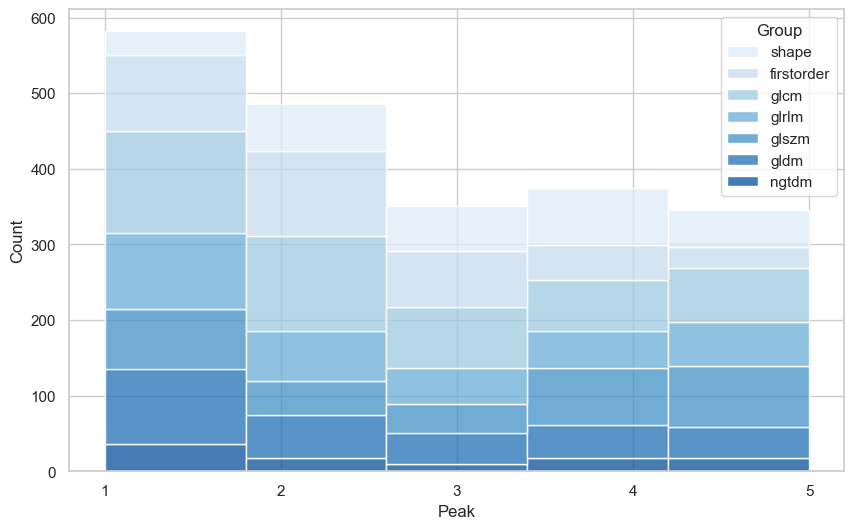

In [31]:
df_result['Group'] = df_result['Feature'].str.split('_').str[0]
# scatter plot of peak values
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_result, x='Peak', hue='Group', multiple='stack', bins=5, palette='Blues')
plt.xticks(np.arange(1, 6, 1))